In [6]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [7]:
import numpy as np

In [82]:
from scipy.stats import norm
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

def rnorm(n,mean,sd):
    """
    same functions as rnorm in r
    r: rnorm(n, mean=0, sd=1)
    py: rvs(loc=0, scale=1, size=1, random_state=None)
    """
    return spark.sparkContext.parallelize(norm.rvs(loc=mean,scale=sd,size=n))


def dnorm(x,mean,sd, log=False):
    """
    same functions as dnorm in r
    dnorm(x, mean=0, sd=1, log=FALSE)
    pdf(x, loc=0, scale=1)
    """
    if log:
        y = np.log(norm.pdf(x=x.collect(),loc=mean,scale=sd))
        return spark.sparkContext.parallelize(y)
    else:
        y = norm.pdf(x=x.collect(),loc=mean,scale=sd)
        return spark.sparkContext.parallelize(y)

def runif(n,min=0, max=1):
    """
    r: runif(n, min = 0, max = 1)
    py: random.uniform(low=0.0, high=1.0, size=None)
    """
    return spark.sparkContext.parallelize(np.random.uniform(min,max,size=n)) 

def dnorm_np(x,mean,sd, log=False):
    """
    same functions as dnorm in r
    dnorm(x, mean=0, sd=1, log=FALSE)
    pdf(x, loc=0, scale=1)
    """
    if log:
        return np.log(norm.pdf(x=x,loc=mean,scale=sd))
    else:
        return norm.pdf(x=x,loc=mean,scale=sd)

In [67]:
import pyspark.sql.functions as F

In [68]:
rnorm(5,10,1).collect()

[10.238732417110164,
 10.264727916303315,
 8.85077226458646,
 10.128028714245518,
 11.75841939918616]

In [69]:
rnorm(5,10,1).sum()

48.408527454590086

In [70]:
s2 = 1
t2 = 10
mu = 5
n = 5 

In [71]:
y = rnorm(n,10,1)
y.collect()

[11.016470307356224,
 9.969016324093525,
 10.987999834057113,
 9.739106369023839,
 10.00969157867778]

In [72]:
y.mean()

10.344456882641696

In [73]:
# mean of the normal posterior
mu_n = (y.mean()*n/s2 + mu/float(t2))/(n/float(s2)+1/float(t2)) 
mu_n

10.239663610433036

In [74]:
# variance of the normal posterior
# t2.n<-1/(n/s2+1/t2)

t2_n = 1.0/(n/float(s2)+1.0/t2)
t2_n

0.19607843137254904

In [75]:
# defining the data
# y<-c(9.37, 10.18, 9.16, 11.60, 10.33)

y = spark.sparkContext.parallelize([9.37, 10.18, 9.16, 11.60, 10.33])

In [81]:
type(y.collect())

list

In [76]:
mu_n = (y.mean()*n/s2 + mu/float(t2))/(n/float(s2)+1/float(t2)) 
mu_n

10.027450980392157

In [77]:
####metropolis part####
##S = total num of simulations
# theta<-0 ; delta<-2 ; S<-10000 ; THETA<-NULL ; set.seed(1)

theta = 0 
delta = 2

S = 10000

theta_v = []

In [78]:
theta_star = norm.rvs(theta,np.sqrt(delta),1)
theta_star


array([-1.06519926])

In [86]:
dnorm(y,theta_star,np.sqrt(s2),log=True).sum()

-319.67490663953623

In [92]:
dnorm(theta_star.rdd,mu,np.sqrt(t2),log=True).sum()

AttributeError: 'numpy.ndarray' object has no attribute 'rdd'

In [89]:
for s in range(S):
    theta_star = norm.rvs(theta,np.sqrt(delta),1)
    
    logr = (dnorm(y,theta_star,np.sqrt(s2),log=True).sum() +\
            dnorm(theta_star.rdd,mu,np.sqrt(t2),log=True).sum())- \
           (dnorm(y,theta,np.sqrt(s2),log=True).sum() + \
            dnorm([theta.rdd],mu,np.sqrt(t2),log=True).sum())
    #print(logr)
    if np.log(runif(1))<logr:
        theta = theta_star
    #print(theta)    
    theta_v.append(theta)  

AttributeError: 'numpy.ndarray' object has no attribute 'rdd'

In [12]:
theta_v[1:10]

[array([1.2295165]),
 array([1.2295165]),
 array([1.2295165]),
 array([3.46382438]),
 array([3.46382438]),
 array([4.05418425]),
 array([4.15016089]),
 array([4.15016089]),
 array([4.15016089])]

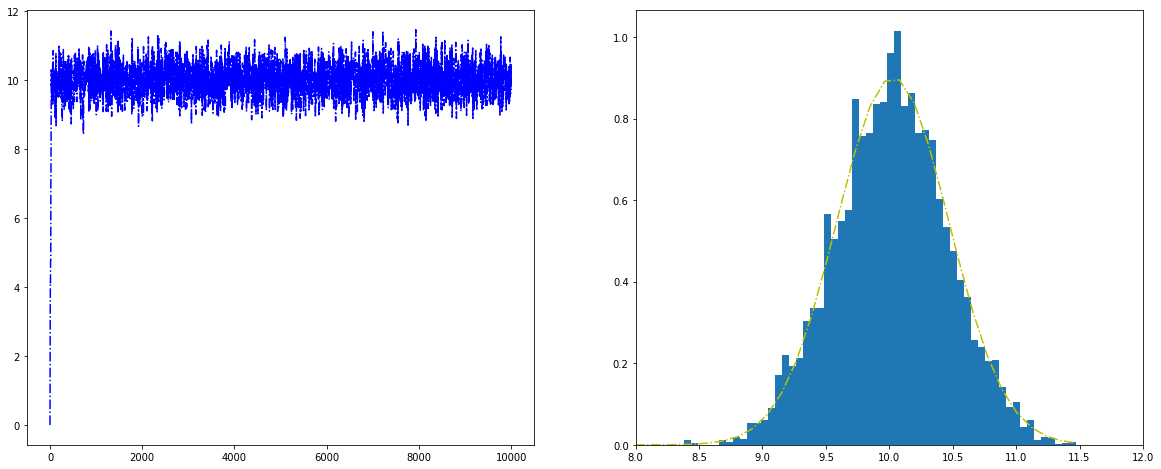

In [14]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(theta_v,'b-.')
        
plt.subplot(1, 2, 2)
#bins = np.arange(0, S, 10) 
plt.hist(theta_v, density=True,bins='auto')
x = np.linspace(min(theta_v),max(theta_v),100) 
y = norm.pdf(x,mu_n,np.sqrt(t2_n))
plt.plot(x,y,'y-.')
plt.xlim(right=12)  # adjust the right leaving left unchanged
plt.xlim(left=8)  # adjust the left leaving right unchanged
plt.show()